In [1]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

/home/priya/miniconda3/envs/exptt/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load training and Validation arrays

In [2]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }


reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [3]:
npzfile = np.load('shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394, 8)


In [4]:
npzfile = np.load('shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800, 8)


### Check by plotting a Spectogram

Experimental


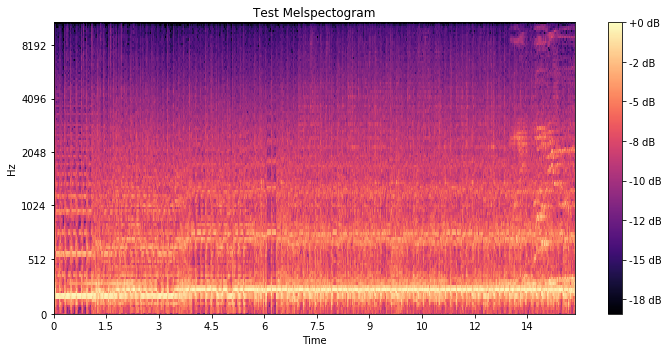

In [6]:
num = 5300
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

### CNN - RNN Model

In [7]:
batch_size = 32
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [8]:
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 100
NUM_HIDDEN = 64
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        layer = Conv1D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)
    
    ## LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Dropout(0.4)(layer)
    
    ## Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization))(layer)
    layer = Dropout(0.4)(layer)
    
    ## Softmax Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    
    
    opt = Adam(lr=0.001)
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [9]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
                              write_images=False, embeddings_freq=0, embeddings_layer_names=None,
                              embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/weights.best.hdf5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [tb_callback, checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history


In [10]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [11]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

Building model...
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 128)         0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, None, 56)          35896     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 56)          224       
_________________________________________________________________
activation_1 (Activation)    (None, None, 56)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 56)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 56)          0         
_________________________________________

6394/6394 [==============================] - 12s 2ms/step - loss: 1.5094 - acc: 0.5188 - val_loss: 2.3029 - val_acc: 0.2487

Epoch 00022: val_acc did not improve from 0.39500
Epoch 23/100
6394/6394 [==============================] - 12s 2ms/step - loss: 1.4864 - acc: 0.5316 - val_loss: 2.4686 - val_acc: 0.2500

Epoch 00023: val_acc did not improve from 0.39500
Epoch 24/100
6394/6394 [==============================] - 13s 2ms/step - loss: 1.4847 - acc: 0.5314 - val_loss: 3.1501 - val_acc: 0.2387

Epoch 00024: val_acc did not improve from 0.39500
Epoch 25/100
6394/6394 [==============================] - 12s 2ms/step - loss: 1.4842 - acc: 0.5336 - val_loss: 1.7599 - val_acc: 0.4275

Epoch 00025: val_acc improved from 0.39500 to 0.42750, saving model to ./models/weights.best.hdf5
Epoch 26/100
6394/6394 [==============================] - 12s 2ms/step - loss: 1.4962 - acc: 0.5249 - val_loss: 2.0272 - val_acc: 0.4012

Epoch 00026: val_acc did not improve from 0.42750
Epoch 27/100
6394/6394 [=

6394/6394 [==============================] - 12s 2ms/step - loss: 1.0854 - acc: 0.6691 - val_loss: 1.6658 - val_acc: 0.4425

Epoch 00063: val_acc did not improve from 0.50625
Epoch 64/100
6394/6394 [==============================] - 12s 2ms/step - loss: 1.1059 - acc: 0.6576 - val_loss: 1.5888 - val_acc: 0.4988

Epoch 00064: val_acc did not improve from 0.50625
Epoch 65/100
6394/6394 [==============================] - 12s 2ms/step - loss: 1.0997 - acc: 0.6656 - val_loss: 1.7489 - val_acc: 0.5225

Epoch 00065: val_acc improved from 0.50625 to 0.52250, saving model to ./models/weights.best.hdf5
Epoch 66/100
6394/6394 [==============================] - 12s 2ms/step - loss: 1.0931 - acc: 0.6650 - val_loss: 1.6787 - val_acc: 0.5125

Epoch 00066: val_acc did not improve from 0.52250
Epoch 67/100
6394/6394 [==============================] - 12s 2ms/step - loss: 1.0862 - acc: 0.6630 - val_loss: 1.6265 - val_acc: 0.5038

Epoch 00067: val_acc did not improve from 0.52250
Epoch 68/100
6394/6394 [=

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


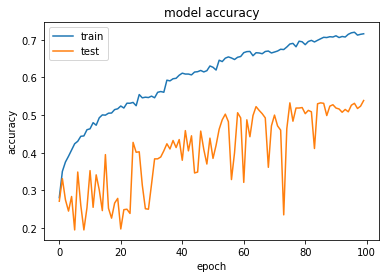

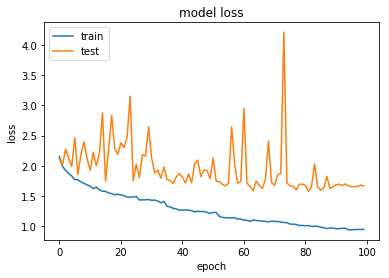

In [12]:
show_summary_stats(history)

In [13]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))


(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.48      0.53      0.50       100
 Experimental       0.46      0.62      0.53       100
         Folk       0.71      0.72      0.72       100
      Hip-Hop       0.67      0.64      0.65       100
 Instrumental       0.51      0.36      0.42       100
International       0.60      0.69      0.64       100
          Pop       0.20      0.15      0.17       100
         Rock       0.62      0.60      0.61       100

    micro avg       0.54      0.54      0.54       800
    macro avg       0.53      0.54      0.53       800
 weighted avg       0.53      0.54      0.53       800



In [14]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.53875
